In [1]:
import enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("./figures.mplstyle")

In [2]:
class BernoulliLikelihood:
    def __init__(self):
        self.n0 = 0
        self.n1 = 0
        
    @property
    def n(self) -> int:
        return self.n0 + self.n1
    
    @property
    def p(self) -> float:
        return self.n1 / self.n
  
    def evaluate(self) -> float:
        return self.p**self.n1 * (1-self.p)**self.n0
    
    def log_evaluate(self) -> float:
        if self.p in {0, 1}:
            return np.log(self.evaluate())
        return self.n1 * np.log(self.p) + self.n0 * np.log(1-self.p)
    
    def update(self, x: float):
        if x:
            self.n1 += 1
        else:
            self.n0 += 1
        return self
        
    def log_likelihood(self, x):
        return self.update(x).log_evaluate()
        #l = self.log_evaluate()
        #self.update(x)
        #return l
    
class TestKind(enum.Enum):
    nonstationary = 1
    increasing = 2
    decreasing = 3

class EWMLikelihood:
    def __init__(self, alpha: float, kind: TestKind = TestKind.nonstationary, p: float = 0.5):
        self.alpha = alpha
        self._p = p
        self._p_alt = p
        self.z = 1
        self.n = 2
        self.n1 = 1
        self.kind = kind
        
    @classmethod
    def from_halflife(cls, h: float, **kwds):
        alpha = 1 - np.exp(-np.log(2) / h)
        return cls(alpha, **kwds)
        
    @property
    def p(self) -> float:
        mle = (self.n1) / (self.n)
        if self.kind is TestKind.nonstationary:
            return self._p
        elif self.kind is TestKind.increasing:
            return max(self._p, mle)
        elif self.kind is TestKind.decreasing:
            return min(self._p, mle)
        else:
            raise NotImplementedError("kind must be of type TestKind")
    
    def evaluate(self, x: float) -> float:
        return self.p**x * (1-self.p)**(1-x)
    
    def log_evaluate(self, x: float) -> float:
        return np.log(self.evaluate(x))
    
    def update(self, x: float):
        self.n1 += 1 if x else 0
        self.n += 1
        self.z += (1-self.alpha)**self.n
        self._p += (x - self._p) / self.z
        return self
    
    def log_likelihood(self, x: float):
        l = self.log_evaluate(x)
        self.update(x)
        return l
    
class BernoulliEProcess:
    def __init__(self, g):
        self.g = g
        self.ll = BernoulliLikelihood()
        self.log_evidence = 0
        
    def log_e(self, x: float):
        evidence_null = self.ll.log_likelihood(x)
        self.log_evidence += self.g.log_likelihood(x)
        #print(self.g.p, self.ll.p, x)
        #print(np.exp(self.log_evidence), np.exp(evidence_null))
        return self.log_evidence - evidence_null

    def evaluate(self, obs):
        for x in obs:
            yield self.log_e(x)
            

def bernoulli(p, n, rng=np.random.default_rng()):
    return rng.binomial(1, p, n)


def p_value(log_e_values):
    return np.exp(-log_e_values.max())

def legend_out(ax, **kws):
    return ax.legend(loc=2, ncol=1, bbox_to_anchor=[1, 1], **kws)

# Stationary Bernoulli

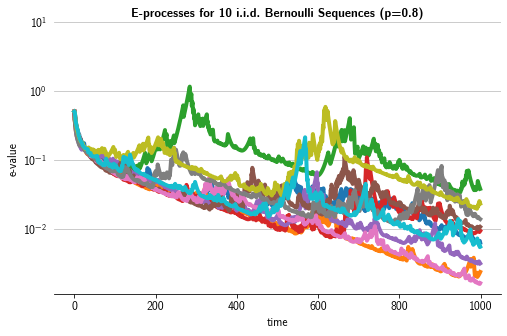

In [3]:
fig, ax = plt.subplots()
for i in range(10):
    obs = bernoulli(0.8, 1000)
    ep = BernoulliEProcess(EWMLikelihood.from_halflife(64))
    ax.plot(np.exp(np.array(list(ep.evaluate(obs)))))



ax.set(
    yscale="log",
    ylim=[None, 10],
    #xlim=[0, 50],
    xlabel="time",
    ylabel="e-value",
    title="E-processes for 10 i.i.d. Bernoulli Sequences (p=0.8)"
)
fig.savefig("figures/iid-bernoulli-e-processes.png", bbox_inches="tight")

In [4]:
np.exp((obs.sum() * np.log(0.7) + (1-obs).sum() * np.log(0.3)) -  (obs.sum() * np.log(0.8) + (1-obs).sum() * np.log(0.2)))

6.67873526437852e-12

# Bernoulli Bandit Reward Sequence

In [5]:
from typing import Tuple

class Bandit:
    def __init__(self, n_arms: int, rng=np.random.default_rng()):
        self.n_arms = n_arms
        self.rng = rng
        self.arm_means = self.rng.uniform(size=self.n_arms)
        
    def pull(self, k: int) -> float:
        mu = self.arm_means[k]
        return bernoulli(mu, 1, rng=self.rng)
            
    def best_arm(self) -> Tuple[int, float]:
        k = self.arm_means.argmax()
        return k, self.arm_means[k]


class BetaThompsonSampler:
    def __init__(self, n_arms: int, rng=np.random.default_rng()):
        self.n1 = np.ones(n_arms)
        self.n0 = np.ones(n_arms)
        self.rng = rng
        
    def choose_arm(self) -> int:
        return np.argmax(self.rng.beta(self.n1, self.n0))
    
    def pull(self, bandit: Bandit) -> float:
        k = self.choose_arm()
        r = bandit.pull(k)
        if r:
            self.n1[k] += 1
        else:
            self.n0[k] += 1
        return r
    
def play(bandit: Bandit, agent: BetaThompsonSampler, n_rounds: int):
    rewards = np.zeros(n_rounds)
    for i in range(n_rounds):
        rewards[i] = agent.pull(bandit)
    return rewards

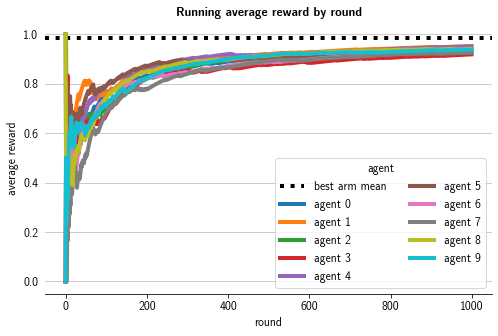

In [6]:
n_agents = 10
n_rounds = 1000
n_arms = 32
bandit = Bandit(n_arms)
rewards = np.zeros((n_rounds, n_agents))
for i in range(n_agents):
    agent = BetaThompsonSampler(n_arms)
    rewards[:, i] = play(bandit, agent, n_rounds)
rewards = pd.DataFrame(rewards)
fig, ax = plt.subplots()
ax.axhline(bandit.best_arm()[1], color="k", ls="dotted", label="best arm mean")
for i in rewards.columns:
    ax.plot(rewards[i].expanding().mean(), label=f"agent {i}")
ax.legend(title="agent", ncol=2)
ax.set(
    ylabel="average reward",
    xlabel="round",
    title="Running average reward by round",
)
None

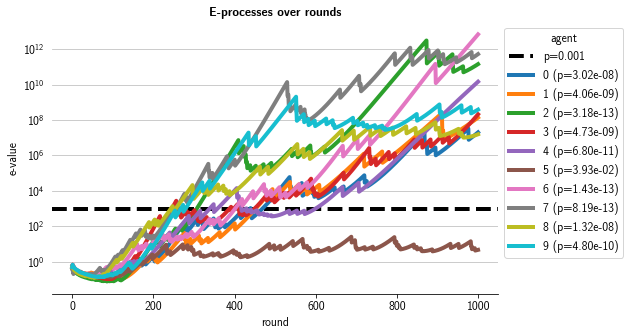

In [7]:
data = {}
for i in range(n_agents):
    ep = BernoulliEProcess(EWMLikelihood.from_halflife(64, kind=TestKind.increasing))
    data[i] = np.array(list(ep.evaluate(rewards[i])))
evalues = pd.DataFrame(data).apply(np.exp)
fig, ax = plt.subplots()
alpha = 0.001
ax.axhline(1/alpha, color="k", ls="dashed", label=f"p={alpha}")
for i in evalues.columns:
    p = 1/evalues[i].max()
    ax.plot(evalues[i], label=f"{i} (p={p:0.2e})")
legend_out(ax, title="agent")
ax.set(
    yscale="log",
    xlabel="round",
    ylabel="e-value",
    title="E-processes over rounds"
)
fig.savefig("figures/bandit-e-processes.png", bbox_inches="tight")

# Real Data

In [8]:
import geopandas as gpd

In [9]:
stops = gpd.read_parquet("./stop-sequence.parquet")

In [10]:
total_drivers = len(stops.groupby("driver_id").size())
total_drivers

593

## Stop  statistics

In [11]:
service_stops = stops.groupby(["driver_id", "stop_count"])[["localtime_start", "localtime_end", "n_pings", "geometry"]].first()
service_stops = service_stops.set_geometry(service_stops.centroid).to_crs(service_stops.crs)

In [12]:
avg_npings = service_stops.n_pings.mean()
avg_duration_minutes = (service_stops.localtime_end - service_stops.localtime_start).apply(lambda td: td.total_seconds()).mean() / 60.0
print(f"The average service stop has {avg_npings} pings and lasts {avg_duration_minutes} minutes.")

The average service stop has 2.827644429588299 pings and lasts 12.52784997635873 minutes.


In [13]:
# Custom webmap implementation
# based on https://github.com/ResidentMario/geoplot/blob/2da7dc7392d0c7525db7585fd741e95c124fe5c6/geoplot/geoplot.py#L1639
from geoplot.geoplot import Plot, GeoAxesSubplot
import contextily as ctx

def webmap(
    df, extent=None, figsize=(8, 6), projection=None, zoom=None,
    provider=ctx.providers.OpenStreetMap.Mapnik, ax=None, **kwargs
):
    """
    A webmap.
    Parameters
    ----------
    df : GeoDataFrame
        The data being plotted.
    projection : geoplot.crs object instance, optional
        The projection to use. For reference see
        :ref:`/user_guide/Working_with_Projections.ipynb`.
        ``webmap`` only supports a single projection: ``WebMercator``.
    extent : None or (min_longitude, min_latitude, max_longitude, max_latitude), optional
        Controls the plot extents. For reference see
        :ref:`/user_guide/Customizing_Plots.ipynb#extent`.
    zoom: None or int
        The zoom level to use when fetching webmap tiles. Higher zoom levels mean more detail,
        but will also take longer to generate and will have more clutter. There are generally
        only two or three zoom levels that are appropriate for any given area. For reference
        see the OpenStreetMaps reference on
        `zoom levels <https://wiki.openstreetmap.org/wiki/Zoom_levels>`_.
    provider: contextily.providers object
        The tile provider. If no provider is set, the default OpenStreetMap tile service,
        contextily.providers.OpenStreetMap.Mapnik, will be used. For reference see `the contextily
        documentation <https://github.com/darribas/contextily>`_.
    figsize : (x, y) tuple, optional
        Sets the size of the plot figure (in inches).
    ax : AxesSubplot or GeoAxesSubplot instance, optional
        If set, the ``matplotlib.axes.AxesSubplot`` or ``cartopy.mpl.geoaxes.GeoAxesSubplot``
        instance to paint the plot on. Defaults to a new Axes.
    kwargs: dict, optional
        Keyword arguments to be passed to the underlying Matplotlib `Polygon patches
        <https://matplotlib.org/api/patches_api.html#matplotlib.patches.Polygon>`_.
    Returns
    -------
    ``AxesSubplot`` or ``GeoAxesSubplot``
        The plot Axes.
    """
    class WebmapPlot(Plot):
        # webmap is restricted to the WebMercator projection, which requires special Axes and
        # projection initialization rules to get right.
        def __init__(self, df, **kwargs):
            if isinstance(ax, GeoAxesSubplot):
                proj_name = ax.projection.__class__.__name__
                if proj_name != 'WebMercator':
                    raise ValueError(
                        f'"webmap" is only compatible with the "WebMercator" projection, but '
                        f'the input Axes is in the {proj_name!r} projection instead. To fix, '
                        f'pass "projection=gcrs.WebMercator()" to the Axes initializer.'
                    )
                super().__init__(df, projection=projection, **kwargs)
            elif isinstance(ax, mpl.axes.Axes):
                raise ValueError(
                    '"webmap" is only compatible with the "WebMercator" projection, but '
                    'the input Axes is unprojected. To fix, pass "projection=gcrs.WebMercator()" '
                    'to the Axes initializer.'
                )
            elif ax is None and projection is None:
                warnings.warn(
                    '"webmap" is only compatible with the "WebMercator" projection, but the '
                    'input projection is unspecified. Reprojecting the data to "WebMercator" '
                    'automatically. To suppress this warning, set '
                    '"projection=gcrs.WebMercator()" explicitly.'
                )
                super().__init__(df, projection=gcrs.WebMercator(), **kwargs)
            elif (ax is None
                  and projection is not None
                  and projection.__class__.__name__ != 'WebMercator'):
                raise ValueError(
                    f'"webmap" is only compatible with the "WebMercator" projection, but '
                    f'the input projection is set to {projection.__class__.__name__!r}. Set '
                    f'projection=gcrs.WebMercator() instead.'
                )
            elif (ax is None
                  and projection is not None
                  and projection.__class__.__name__ == 'WebMercator'):
                super().__init__(df, projection=projection, **kwargs)

            zoom = kwargs.pop('zoom', None)

            # The plot extent is a well-defined function of plot data geometry and user input to
            # the "extent" parameter, except in the case of numerical instability or invalid user
            # input, in which case the default plot extent for the given projection is used. But
            # the default extent is not well-exposed inside of the Cartopy API, so in edge cases
            # where we are forced to fall back to default extent we don't actually know the true
            # plot extent.
            #
            # For this reason we (1) recalculate "good case" plot extent here, instead of saving
            # the value to an init variable and (2) accept that this calculation is potentially
            # incorrect in edge cases.
            extent = relax_bounds(*self.df.total_bounds) if self.extent is None else self.extent

            if zoom is None:
                zoom = ctx.tile._calculate_zoom(*extent)
            else:
                howmany = ctx.tile.howmany(*extent, zoom, ll=True, verbose=False)
                if howmany > 100:
                    better_zoom_level = ctx.tile._calculate_zoom(*extent)
                    warnings.warn(
                        f'Generating a webmap at zoom level {zoom} for the given plot extent '
                        f'requires downloading {howmany} individual tiles. This slows down '
                        f'plot generation and places additional pressure on the tile '
                        f'provider\'s server, which many deny your request when placed under '
                        f'high load or high request volume. Consider setting "zoom" to '
                        f'{better_zoom_level} instead. This is the recommended zoom level for '
                        f'the given plot extent.'
                    )
            self.zoom = zoom
            self._webmap_extent = extent
            # Regular plots have zorder 0, polyplot has zorder -1, webmap has zorder -2.
            # This reflects the order we usually want these plot elements to appear in.
            self.zorder = kwargs.pop('zorder', -2)
            kwargs.pop('extent')
            kwargs.pop('figsize')
            kwargs.pop('ax')
            self.kwargs = kwargs

        def draw(self):
            ax = plot.ax
            if len(self.df.geometry) == 0:
                return ax

            basemap, extent = ctx.bounds2img(
                *self._webmap_extent, zoom=self.zoom,
                source=provider, ll=True
            )
            ax.imshow(basemap, extent=extent, interpolation='bilinear', zorder=self.zorder, **self.kwargs)
            return ax

    plot = WebmapPlot(df, figsize=figsize, ax=ax, extent=extent, zoom=zoom, **kwargs)
    return plot.draw()

/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-par

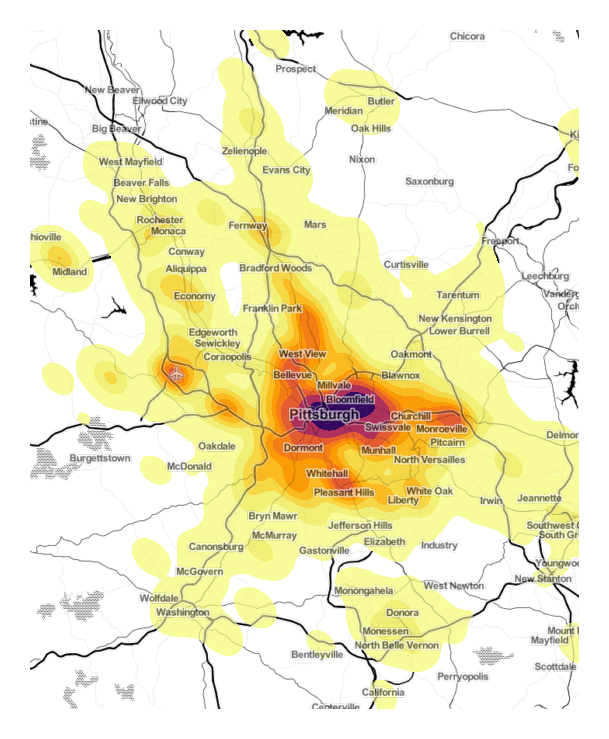

In [14]:
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as ctx
import matplotlib as mpl
extent = (-80.51605224609375, 40.042334918180536, -79.54376220703125, 40.95708558389897)
with mpl.rc_context({'figure.dpi': 300}):
    ax = gplt.webmap(
        service_stops,
        projection=gcrs.WebMercator(),
        provider=ctx.providers.Stamen.TonerBackground,
        figsize=(3, 3),
        extent=extent,
    )

    gplt.kdeplot(service_stops, shade=True,  thresh=0.01, ax=ax, extent=extent, cmap="inferno_r")
    webmap(
        service_stops,
        projection=gcrs.WebMercator(),
        provider=ctx.providers.Stamen.TonerLines,
        extent=extent,
        ax=ax,
        zorder=1,
        alpha=0.4
    )
    webmap(
        service_stops,
        projection=gcrs.WebMercator(),
        provider=ctx.providers.Stamen.TonerLabels,
        extent=extent,
        ax=ax,
        zorder=1,
        alpha=0.6
    )
    plt.savefig("figures/service-stop-kde.png", bbox_inches="tight")

In [15]:
service_stop_times = stops.groupby(["driver_id", "stop_count"]).localtime_start.first()

In [16]:
open_counts = (
    stops.groupby(["driver_id", "stop_count", "tag"])
         .is_open
         .sum()
         .rename("open_count")
         .reset_index()
         .pivot(columns="tag", values="open_count", index=["driver_id", "stop_count"])
         .fillna(0.0)
).sort_index()
# minor custom tag stuff
open_counts["building:office"] = open_counts["building:office"] + open_counts["building:offices"]
open_counts["building:residential"] = open_counts["building:residential"] + open_counts["building:apartments"]
open_tag = (open_counts > 0).astype(np.float64).sort_index()

In [17]:
n_service_stops = open_tag.groupby("driver_id").size()
min_number_service_stops = 500
selected_drivers = n_service_stops[n_service_stops > min_number_service_stops].index
total_number_of_drivers = len(n_service_stops)
print(f"Selected {len(selected_drivers)} drivers out of {len(n_service_stops)}")

Selected 106 drivers out of 571


In [18]:
stop_tags_ts = (
    open_tag.join(service_stop_times)
             .set_index("localtime_start", append=True)
             .sort_index(level="localtime_start")
)

In [19]:
select_tags = [
    "aeroway:aerodrome",
    "amenity:arts_centre",
    "amenity:bank",
    "amenity:bar",
    "amenity:cafe",
    "amenity:casino",
    "amenity:childcare",
    "amenity:cinema",
    "amenity:college",
    "amenity:concert_hall",
    "amenity:courthouse",
    "amenity:crematorium",
    "amenity:dentist",
    "amenity:doctors",
    "amenity:events_centre",
    "amenity:events_venue",
    "amenity:fast_food",
    "amenity:funeral_home",
    "amenity:grave_yard",
    "amenity:hospital",
    "amenity:library",
    "amenity:nightclub",
    "amenity:place_of_worship",
    "amenity:pub",
    "amenity:restaurant",
    "amenity:shelter",
    "amenity:theatre",
    "amenity:university",
    "building:commercial",
    "building:residential",
    "building:office"
]

In [155]:
alpha = 0.05 / 2.0

def log_e_values(obs, kind=TestKind.nonstationary, halflife=64):
    ep = BernoulliEProcess(EWMLikelihood.from_halflife(halflife, kind=kind))
    log_evalues = np.fromiter(ep.evaluate(obs), dtype=np.float64)
    return pd.Series(log_evalues, index=obs.index)

# Tag Seeking Test

In [21]:
evalues_seek = open_tag.loc[selected_drivers, select_tags].groupby("driver_id").transform(
    log_e_values, kind=TestKind.increasing
)

In [22]:
pvalues_seek = evalues_seek.groupby("driver_id").agg(p_value)

In [23]:
corrected_alpha = alpha / pvalues_seek.size

In [24]:
pvalues_seek_long = pvalues_seek.unstack()
significant = pvalues_seek_long <= corrected_alpha
print(f"Found {significant.sum()} significant variables (out of {significant.size})")

Found 62 significant variables (out of 3286)


In [25]:
p_table_seek = ((pvalues_seek.size * pvalues_seek_long[pvalues_seek_long <= corrected_alpha]).sort_values()
 .rename("p_value")
 .to_frame()
 .reset_index()
 .drop(columns="driver_id").set_index("tag")
 .groupby("tag").agg(p_value=("p_value","min"), n=("p_value", "count")).sort_values("p_value")
)
p_table_seek.sort_values(by="p_value")

p_value   n
tag                                        
amenity:restaurant        3.147976e-158   4
building:commercial       3.720033e-127   8
amenity:college            9.019750e-63   1
aeroway:aerodrome          1.257241e-59  10
amenity:shelter            8.838479e-40   6
building:residential       1.307362e-37  17
amenity:place_of_worship   2.567874e-16   1
amenity:grave_yard         2.011051e-12   1
amenity:fast_food          1.557675e-08   5
amenity:casino             1.917971e-07   1
amenity:library            3.371288e-07   1
amenity:university         2.525213e-06   2
amenity:doctors            1.522318e-04   2
amenity:dentist            2.831314e-04   1
amenity:bar                4.289036e-03   1
amenity:cinema             8.197497e-03   1

In [26]:
with open("figures/p-table-seek.tex", "w") as fp:
    fp.write(
        p_table_seek.rename(
            columns={"p_value": "p value"}
        ).reset_index().to_latex(
            caption="Bonferroni-corrected p-values for tags from driver-tag pairs exhibiting tag-seeking behavior.",
            float_format="{:0.2e}".format,
            label="tab:pvalues:seek",
            index=False,
            position="h",
        )
    )

4918bd52-4031-447e-90f4-6655fa393d96 amenity:restaurant
4918bd52-4031-447e-90f4-6655fa393d96 building:commercial
79405279-c433-4a77-bef7-7ab638a3332f amenity:college
79405279-c433-4a77-bef7-7ab638a3332f aeroway:aerodrome
ba293aba-6b2e-474f-8ea8-66eb1a54386c amenity:shelter
b3f17f65-7c93-4ae2-9ba1-40a69f067262 building:residential
2e036859-7cb9-40c6-bed5-d9c13ccfd625 amenity:place_of_worship
f99732df-d75c-419b-9978-7e254f5e9d2c amenity:grave_yard
4918bd52-4031-447e-90f4-6655fa393d96 amenity:fast_food
418b8c31-bf8d-4b8c-8c0b-cb4883e6b95c amenity:casino


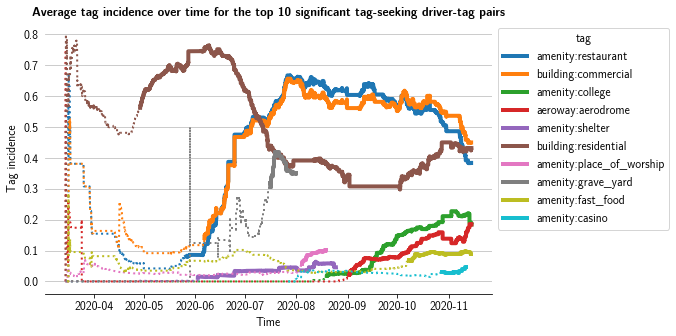

In [27]:
fig, ax = plt.subplots()
width=6
height=4
import datetime as dt
colors = iter(plt.get_cmap("tab10").colors)
seen = set([])
for (tag, driver_id), p_val in pvalues_seek_long[pvalues_seek_long <= corrected_alpha].sort_values().iteritems():
    if len(seen) == 10:
        break
    if tag in seen:
        continue
    seen.add(tag)
    print(driver_id, tag)
    _evalues = evalues_seek.loc[driver_id, tag]
    t_change = _evalues[_evalues > np.log(1/corrected_alpha)].index[0]
    change_pt = stop_tags_ts.loc[driver_id, [tag]].loc[t_change].index[0]
    _df = stop_tags_ts.loc[driver_id, [tag]].reset_index("stop_count", drop=True).rolling(dt.timedelta(days=60), min_periods=1).mean()
    #(_df[tag]).plot(drawstyle="steps", ax=ax)
    #ax.plot(change_pt, "*")
    color = next(colors)
    ax.plot(_df.loc[:change_pt, tag], ds="steps", color=color, ls="dotted", lw=2)
    ax.plot(_df.loc[change_pt:, tag], ds="steps", color=color, ls="solid", label=tag)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(
    xlabel="Time",
    ylabel="Tag incidence",
    title="Average tag incidence over time for the top 10 significant tag-seeking driver-tag pairs")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")
fig.savefig("figures/sig-seek-tag-prob-over-time.png", bbox_inches="tight")

# Tag Avoiding Test

In [28]:
evalues_avoid = open_tag.loc[selected_drivers, select_tags].groupby("driver_id").transform(
    log_e_values, kind=TestKind.decreasing
)

In [29]:
pvalues_avoid = evalues_avoid.groupby("driver_id").agg(p_value)

In [30]:
corrected_alpha = alpha / pvalues_avoid.size

In [31]:
pvalues_avoid_long = pvalues_avoid.unstack()
significant = pvalues_avoid_long <= corrected_alpha
print(f"Found {significant.sum()} significant variables (out of {significant.size})")

Found 55 significant variables (out of 3286)


In [32]:
p_table_avoid = ((pvalues_avoid.size * pvalues_avoid_long[pvalues_avoid_long <= corrected_alpha]).sort_values()
 .rename("p_value")
 .to_frame()
 .reset_index()
 .drop(columns="driver_id").set_index("tag")
 .groupby("tag").agg(p_value=("p_value","min"), n=("p_value", "count")).sort_values("p_value")
)
p_table_avoid

p_value   n
tag                                   
aeroway:aerodrome     3.849116e-62  17
building:residential  8.925666e-43  14
building:commercial   2.233820e-32   5
amenity:restaurant    1.810615e-16   4
amenity:fast_food     1.401175e-14   7
amenity:shelter       1.744978e-14   3
amenity:university    6.362901e-10   1
amenity:casino        2.552072e-08   1
amenity:cafe          5.721490e-05   1
building:office       6.941563e-03   1
amenity:hospital      7.657037e-03   1

In [33]:
with open("figures/p-table-avoid.tex", "w") as fp:
    fp.write(
        p_table_avoid.rename(
            columns={"p_value": "p value"}
        ).reset_index().to_latex(
            caption="Bonferroni-corrected p-values for tags from driver-tag pairs exhibiting tag-avoiding behavior.",
            float_format="{:0.2e}".format,
            label="tab:pvalues:avoid",
            index=False,
            position="h",
        )
    )

733e2b4a-74f3-4cae-ac0a-b68fe84c0382 aeroway:aerodrome
b3f17f65-7c93-4ae2-9ba1-40a69f067262 building:residential
c45c6fb3-119c-41ad-aeda-be1597271edf building:commercial
4918bd52-4031-447e-90f4-6655fa393d96 amenity:restaurant
2e036859-7cb9-40c6-bed5-d9c13ccfd625 amenity:fast_food
7719f001-d699-4a25-9093-1e9770515c11 amenity:shelter
ba293aba-6b2e-474f-8ea8-66eb1a54386c amenity:university
c0ab7340-ecae-42c9-ba91-641bf4e3cfec amenity:casino
ba293aba-6b2e-474f-8ea8-66eb1a54386c amenity:cafe
a33877db-3363-4ba8-a529-f5825ef1f17f building:office


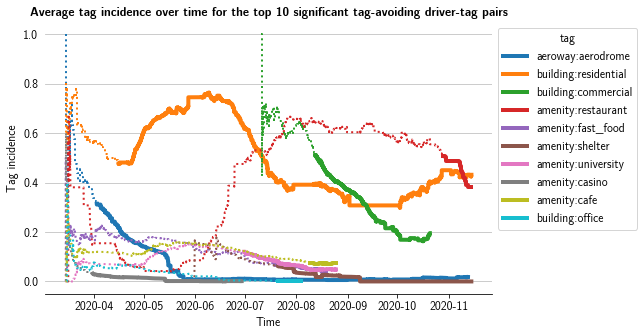

In [34]:
fig, ax = plt.subplots()
width=5
height=3
seen = set([])
colors = iter(plt.get_cmap("tab10").colors)
for (tag, driver_id), p_val in pvalues_avoid_long[pvalues_avoid_long <= corrected_alpha].sort_values().iteritems():
    if len(seen) == 10:
        break
    if tag in seen:
        continue
    seen.add(tag)
    print(driver_id, tag)
    _evalues = evalues_avoid.loc[driver_id, tag]
    t_change = _evalues[_evalues > np.log(1/corrected_alpha)].index[0]
    change_pt = stop_tags_ts.loc[driver_id, [tag]].loc[t_change].index[0]
    _df = stop_tags_ts.loc[driver_id, [tag]].reset_index("stop_count", drop=True).sort_index().rolling(dt.timedelta(days=60)).mean()
    #_df[tag].plot(drawstyle="steps",)
    color = next(colors)
    ax.plot(_df.loc[:change_pt, tag], ds="steps", color=color, ls="dotted", lw=2)
    ax.plot(_df.loc[change_pt:, tag], ds="steps", color=color, ls="solid", label=tag)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(
    xlabel="Time",
    ylabel="Tag incidence",
    title="Average tag incidence over time for the top 10 significant tag-avoiding driver-tag pairs")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-neg-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")
fig.savefig("figures/sig-avoid-tag-prob-over-time.png", bbox_inches="tight")

## Deep Dive

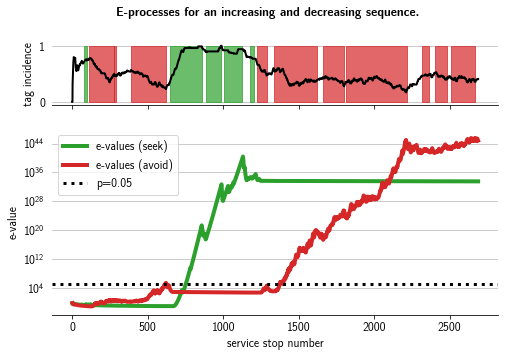

In [35]:
import matplotlib.ticker
driver_id, tag = "b3f17f65-7c93-4ae2-9ba1-40a69f067262", "building:residential"
fig, (ax2, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1, 3]})

ax2.plot(open_tag.loc[driver_id, tag].rolling(100, min_periods=0).mean(), color="k", lw=2, label="tag incidence")

ax1.plot(evalues_seek.loc[driver_id, tag].apply(np.exp), color="tab:green", label="e-values (seek)")
ax1.plot(evalues_avoid.loc[driver_id, tag].apply(np.exp), color="tab:red", label="e-values (avoid)")
ax1.axhline(1/corrected_alpha, color="k", ls="dotted", lw=3, label=f"p={2*alpha}")

w = 32
accumulating_seek = evalues_seek.loc[driver_id, tag].rolling(
    w, min_periods=0, center=True).mean().diff().rolling(w, min_periods=0, center=True).mean()
accumulating_avoid = evalues_avoid.loc[driver_id, tag].rolling(
    w, min_periods=0, center=True).mean().diff().rolling(w, min_periods=0, center=True).mean()

t = evalues_seek.loc[driver_id, tag].index
bot, top = 0*t, 0*t+1

ax2.fill_between(t, bot, top, where=accumulating_seek>=0.0, color="tab:green", alpha=0.7)
ax2.fill_between(t, bot, top, where=(accumulating_avoid>=0.0) & (accumulating_seek<0), color="tab:red", alpha=0.7)


ax1.set(yscale="log", xlabel="service stop number", ylabel="e-value")
ax2.set(
    ylabel="tag incidence",
    #title=f"Moving average {tag} tag incidence",
)

ax1.legend(loc="upper left")
#ax2.legend(loc="upper right")
fig.suptitle(f"E-processes for an increasing and decreasing sequence.")
fig.savefig("figures/e-process-example.png", bbox_inches="tight")

## same tag different driver

building:residential: 17 seekers, 14 avoiders, 7 in both


/tmp/ipykernel_318423/72570475.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  stop_tags_ts.loc[driver_id, tag]


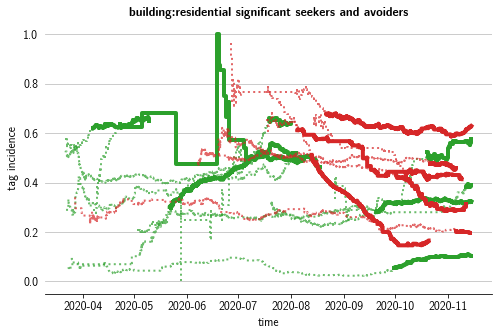

In [36]:
tag = "building:residential"
seekers = set(pvalues_seek[pvalues_seek[tag] <= corrected_alpha].index)
avoiders = set(pvalues_avoid[pvalues_avoid[tag] <= corrected_alpha].index)
opportunists = set(seekers) & set(avoiders)
print(f"{tag}: {len(seekers)} seekers, {len(avoiders)} avoiders, {len(opportunists)} in both")
seekers = seekers - opportunists
avoiders = avoiders - opportunists
#fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
fig, ax = plt.subplots()
axs=[ax, ax]
colors = ["tab:green", "tab:red", "tab:orange"]
for i, group in  enumerate([seekers, avoiders]):#, opportunists]):
    for driver_id in group:
        ts = (
            stop_tags_ts.loc[driver_id, tag]
                        .reset_index("stop_count", drop=True)
                        .rolling(dt.timedelta(days=60), min_periods=0)
                        .mean()
        )
        _evalues = evalues_seek.loc[driver_id, tag]
        try:
            t_change = _evalues[_evalues > np.log(1/corrected_alpha)].index[0]
            change_pt_seek = stop_tags_ts.loc[driver_id, [tag]].loc[t_change].index[0]
        except IndexError:
            change_pt_seek = stop_tags_ts.loc[driver_id, [tag]].index[-1][1]
        _evalues = evalues_avoid.loc[driver_id, tag]
        try:
            t_change = _evalues[_evalues > np.log(1/corrected_alpha)].index[0]
            change_pt_avoid = stop_tags_ts.loc[driver_id, [tag]].loc[t_change].index[0]
        except IndexError:
            change_pt_avoid = stop_tags_ts.loc[driver_id, [tag]].index[-1][1]
        (t1, c1), (t2, c2) = sorted([(change_pt_seek, "tab:green"), (change_pt_avoid, "tab:red")])
        t0 = ts.index[0] + dt.timedelta(days=7)
        axs[i].plot(ts.loc[t0:t1], color=c1, ds="steps", ls="dotted", lw=2, alpha=0.7)
        axs[i].plot(ts.loc[t1:t2], color=c1, ds="steps")
        axs[i].plot(ts.loc[t2:], color=c2, ds="steps")
ax.set(
    xlabel="time",
    ylabel="tag incidence",
    title=f"{tag} significant seekers and avoiders"
)
fig.savefig("figures/tag-seekers-avoider.png", bbox_inches="tight")

/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-par

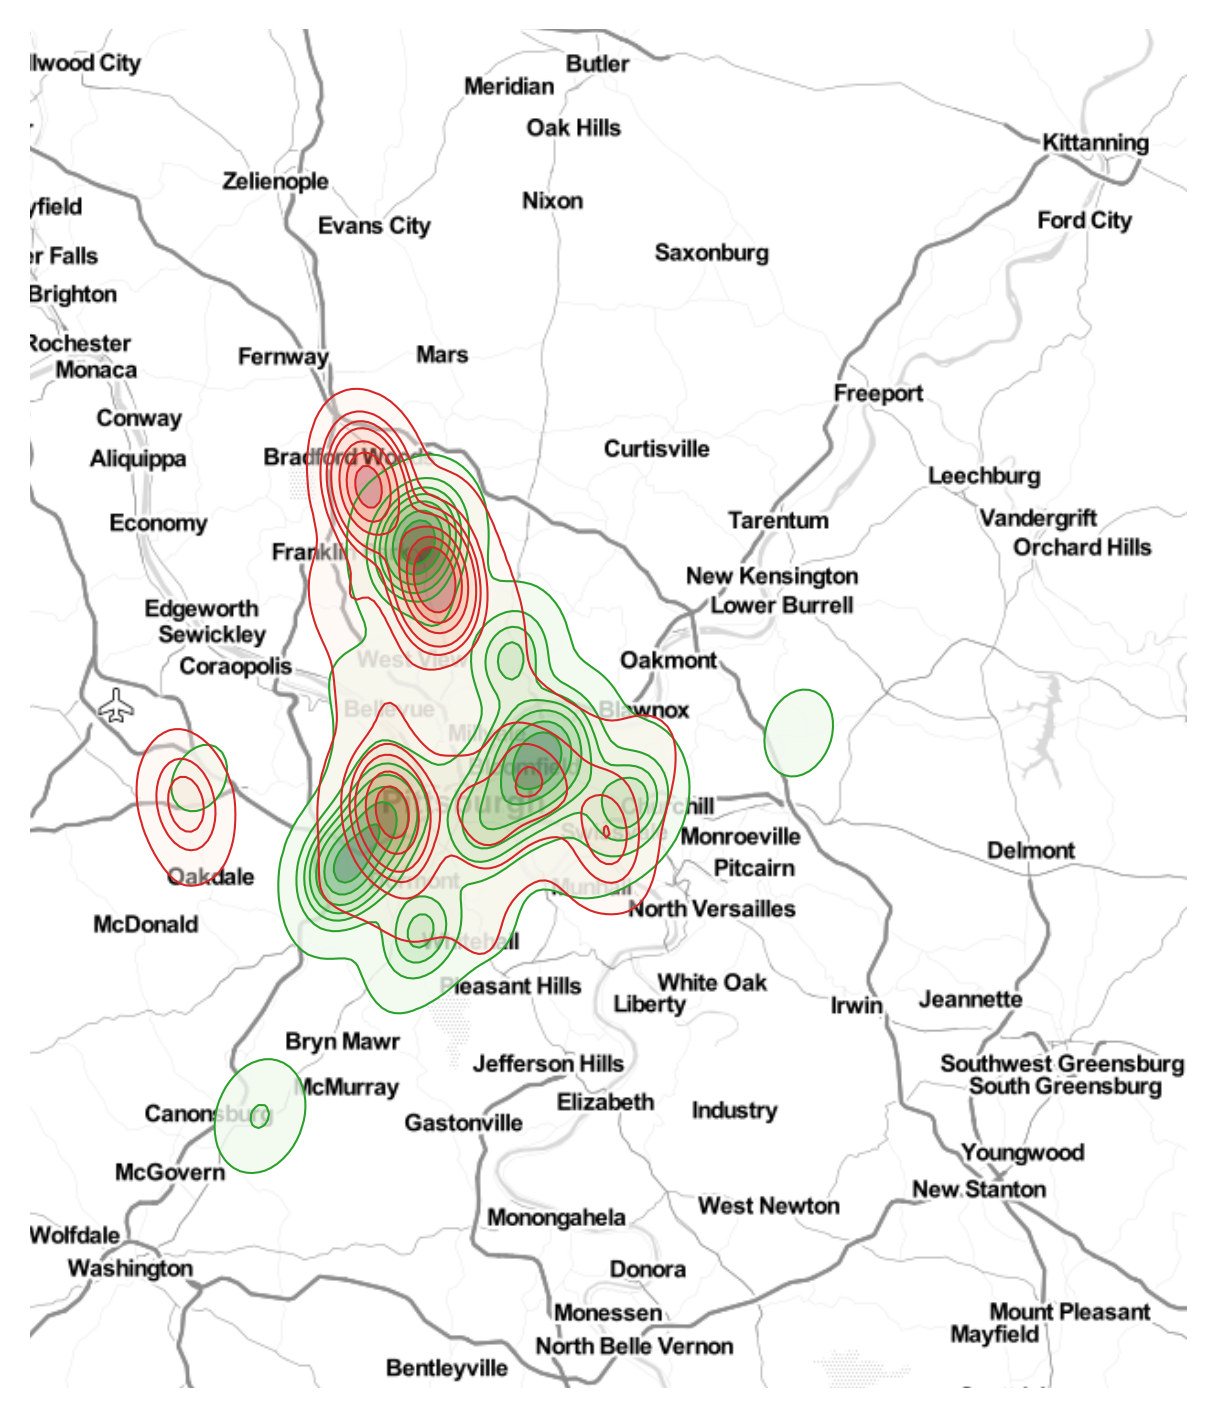

In [37]:
_df = service_stops.loc[seekers].join(open_tag[tag]).dropna()
_df2 = service_stops.loc[avoiders].join(open_tag[tag]).dropna()
levels=8
with mpl.rc_context({'figure.dpi': 300}):
    ax = gplt.webmap(
        _df,
        projection=gcrs.WebMercator(),
        provider=ctx.providers.Stamen.TonerLite,
        figsize=(6, 6),
        extent=extent,
    )
    gplt.kdeplot(_df[_df[tag]>0], shade=True, n_levels=levels, thresh=0.05, ax=ax, cmap="Greens", alpha=0.8)
    gplt.kdeplot(_df2[_df2[tag]>0], shade=True, n_levels=levels, thresh=0.05, ax=ax,cmap="Reds", alpha=0.4)

    gplt.kdeplot(_df[_df[tag]>0], extent=extent, ax=ax, n_levels=levels, linewidths=0.5, color="tab:green")
    gplt.kdeplot(_df2[_df2[tag]>0], n_levels=levels, ax=ax, linewidths=0.5, color="tab:red")
    plt.savefig("figures/tag-seekers-avoiders-map.png", bbox_inches="tight")

/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/matt/.cache/pypoetry/virtualenvs/spad-SfzgOiZd-py3.8/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-par

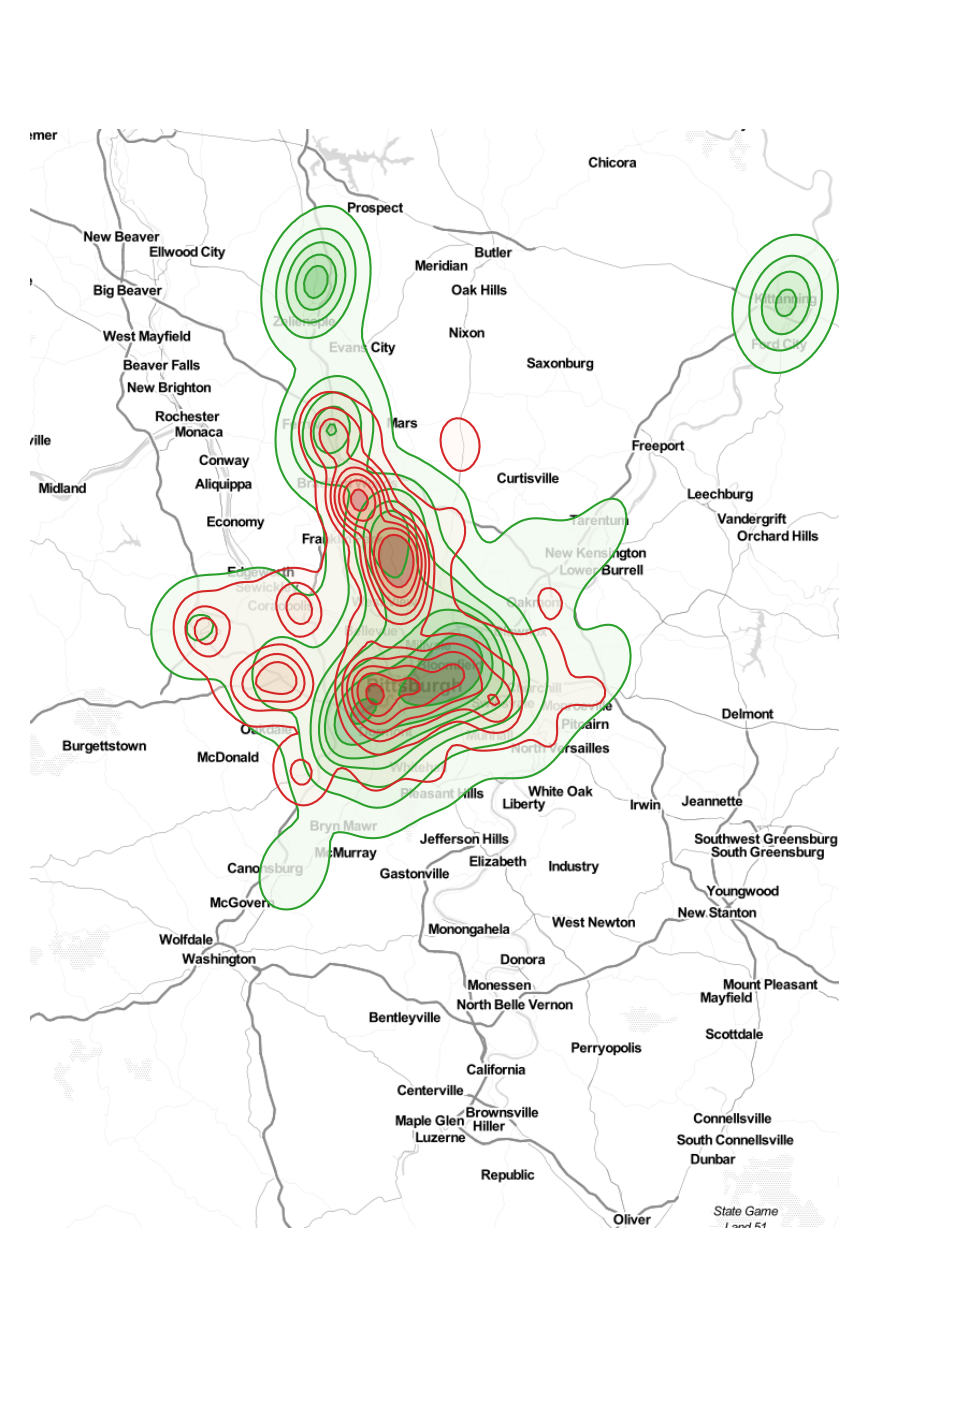

In [38]:
_df = service_stops.loc[seekers].join(open_tag[tag]).dropna()
_df2 = service_stops.loc[avoiders].join(open_tag[tag]).dropna()
levels=8
with mpl.rc_context({'figure.dpi': 300}):
    ax = gplt.webmap(
        _df,
        projection=gcrs.WebMercator(),
        provider=ctx.providers.Stamen.TonerLite,
        figsize=(6, 6),
        extent=extent,
    )
    gplt.kdeplot(_df, shade=True, n_levels=levels, thresh=0.05, ax=ax, cmap="Greens", alpha=0.8)
    gplt.kdeplot(_df2, shade=True, n_levels=levels, thresh=0.05, ax=ax,cmap="Reds", alpha=0.4)

    gplt.kdeplot(_df, extent=extent, ax=ax, n_levels=levels, linewidths=0.5, color="tab:green")
    gplt.kdeplot(_df2, n_levels=levels, ax=ax, linewidths=0.5, color="tab:red")
    plt.savefig("figures/tag-seekers-avoiders-map.png", bbox_inches="tight")

## Summary Table

In [39]:
def n_significant(ps):
    return (ps <= corrected_alpha).sum()
seek_table = pvalues_seek.unstack().groupby("tag").agg(["min", n_significant]).rename(columns={"min": "best p-value", "n_significant": "n"})
seek_table.columns = pd.MultiIndex.from_product([["Seeking"], seek_table.columns])
avoid_table = pvalues_avoid.unstack().groupby("tag").agg(["min", n_significant]).rename(columns={"min": "best p-value", "n_significant": "n"})
avoid_table.columns = pd.MultiIndex.from_product([["Avoiding"], avoid_table.columns])

with open("figures/all-p-values-table.tex", "w") as fp:
    fp.write(
        seek_table.join(avoid_table).reset_index().style.applymap(
            lambda v: "font-weight: bold;" if v <= corrected_alpha else "",
            subset=[("Seeking", "best p-value"), ("Avoiding", "best p-value")]
        ).format(
            "{:0.2e}".format,
            subset=[("Seeking", "best p-value"), ("Avoiding", "best p-value")]
        ).applymap(
            lambda v: "font-weight: bold;" if v else "",
            subset=[("Seeking", "n"), ("Avoiding", "n")]
        ).format(
            lambda v: "{:d}".format(v) if v else "",
            subset=[("Seeking", "n"), ("Avoiding", "n")]
        ).format(
            lambda s: s.replace("_", "\_"),
            subset="tag"
        ).hide_index().to_latex(
            convert_css=True,
            caption="Summary of test results",
            label="tab:all-p-values",
            hrules=True,
            position_float="centering",
            position="h",
        )
    )


# Aggregate Stops

In [292]:
# evalues_avoid = open_tag.loc[selected_drivers, select_tags].groupby("driver_id").transform(
#     log_e_values, kind=TestKind.decreasing
# )
import datetime as dt
t0 = dt.datetime(2020, 4, 1)
_tag_ts = stop_tags_ts.reset_index(["driver_id", "stop_count"], drop=True).sort_index()
aggregate_seek = _tag_ts[select_tags].apply(
    log_e_values, kind=TestKind.increasing, halflife=6000)
aggregate_avoid = _tag_ts[select_tags].apply(
    log_e_values, kind=TestKind.decreasing, halflife=6000)

In [293]:
corrected_alpha = 0.05 / 2.0 / len(select_tags)

In [294]:
aggregate_seek_p = p_value(aggregate_seek)
aggregate_seek_p.index.name = "tag"
aggregate_avoid_p = p_value(aggregate_avoid)
aggregate_avoid_p.index.name = "tag"

In [295]:
agg_seek_p_table = (aggregate_seek_p[aggregate_seek_p <= corrected_alpha].sort_values().rename("p value").to_frame() * corrected_alpha).join((aggregate_seek > np.log(1/corrected_alpha)).idxmax().rename("first detected"))

In [296]:
agg_avoid_p_table = (aggregate_avoid_p[aggregate_avoid_p <= corrected_alpha].sort_values().rename("p value").to_frame() * corrected_alpha).join((aggregate_avoid > np.log(1/corrected_alpha)).idxmax().rename("first detected")) 

In [302]:
agg_seek_p_table.sort_values("first detected")

p value          first detected
tag                                                        
building:commercial    2.051593e-60 2020-04-14 02:30:59.047
amenity:fast_food     3.425917e-104 2020-04-21 19:46:07.441
building:residential   3.919897e-16 2020-05-01 17:06:29.999
amenity:restaurant     1.220971e-76 2020-05-05 18:40:57.001
amenity:cafe           6.535148e-11 2020-05-23 12:52:53.143
amenity:shelter        1.236892e-29 2020-05-30 19:49:09.731
amenity:theatre        5.940681e-07 2020-06-08 20:47:15.070
amenity:grave_yard     9.459494e-39 2020-07-12 22:41:35.114
amenity:casino         1.328287e-17 2020-08-08 18:34:05.000
amenity:college        1.579249e-69 2020-09-09 14:57:19.000
amenity:university     1.456466e-18 2020-09-10 07:16:22.163
aeroway:aerodrome      3.205337e-29 2020-09-10 22:53:09.000
amenity:hospital       1.408093e-10 2020-09-18 07:56:58.000
amenity:bar            2.926920e-12 2020-10-31 18:52:31.048
building:office        1.813575e-07 2020-11-02 15:11:41.000

In [298]:
agg_avoid_p_table

p value          first detected
tag                                                       
aeroway:aerodrome     0.000000e+00 2020-03-27 21:25:11.512
amenity:casino        2.626955e-31 2020-03-22 20:09:48.494
amenity:dentist       3.300727e-26 2020-05-26 09:22:41.397
building:residential  4.016951e-24 2020-08-12 19:34:19.999
amenity:arts_centre   1.711110e-15 2020-06-11 09:51:00.001
amenity:university    1.917654e-08 2020-06-26 23:11:47.998

In [299]:
with open("figures/agg-p-table-avoid.tex", "w") as fp:
    fp.write(
        agg_avoid_p_table.reset_index().to_latex(
            caption="Bonferroni-corrected p-values for significant tag-avoiding behavior.",
            float_format="{:0.2e}".format,
            label="tab:pvalues:agg-avoid",
            index=False,
            position="ht",
        )
    )
with open("figures/agg-p-table-seek.tex", "w") as fp:
    fp.write(
        agg_seek_p_table.reset_index().to_latex(
            caption="Bonferroni-corrected p-values for significant tag-seeking behavior.",
            float_format="{:0.2e}".format,
            label="tab:pvalues:agg-seek",
            index=False,
            position="ht",
        )
    )

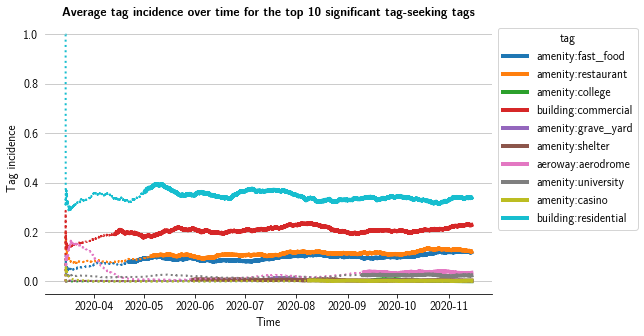

In [306]:
fig, ax = plt.subplots()
width=5
height=3
seen = set([])
colors = iter(plt.get_cmap("tab10").colors)
for tag, p_val in aggregate_seek_p[aggregate_seek_p <= corrected_alpha].sort_values().iteritems():
    if len(seen) == 10:
        break
    if tag in seen:
        continue
    seen.add(tag)
    _evalues = aggregate_seek[tag]
    change_pt = _evalues[_evalues > np.log(1/corrected_alpha)].index[0]
    _df = _tag_ts[tag].rolling(dt.timedelta(days=14)).mean()
    #_df = _tag_ts[tag].ewm(halflife=6000).mean()
    color = next(colors)
    ax.plot(_df.loc[:change_pt], ds="steps", color=color, ls="dotted", lw=2)
    ax.plot(_df.loc[change_pt:], ds="steps", color=color, ls="solid", label=tag)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(
    xlabel="Time",
    ylabel="Tag incidence",
    title="Average tag incidence over time for the top 10 significant tag-seeking tags")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-neg-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")
fig.savefig("figures/agg-sig-seek-tag-prob-over-time.png", bbox_inches="tight")

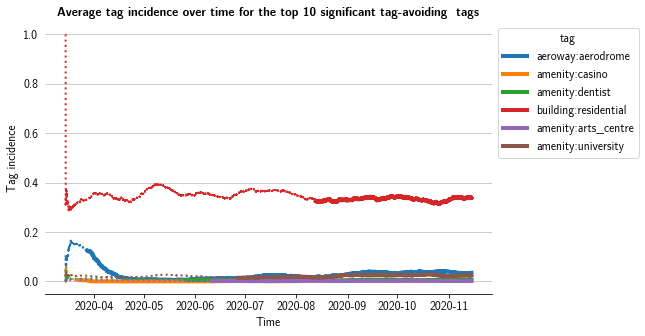

In [307]:
fig, ax = plt.subplots()
width=5
height=3
seen = set([])
colors = iter(plt.get_cmap("tab10").colors)
for tag, p_val in aggregate_avoid_p[aggregate_avoid_p <= corrected_alpha].sort_values().iteritems():
    if len(seen) == 10:
        break
    if tag in seen:
        continue
    seen.add(tag)
    _evalues = aggregate_avoid[tag]
    change_pt = _evalues[_evalues > np.log(1/corrected_alpha)].index[0]
    _df = _tag_ts[tag].rolling(dt.timedelta(days=14), min_periods=1).mean()
    #_df = _tag_ts[tag].ewm(halflife=6000).mean()
    color = next(colors)
    ax.plot(_df.loc[:change_pt], ds="steps", color=color, ls="dotted", lw=2)
    ax.plot(_df.loc[change_pt:], ds="steps", color=color, ls="solid", label=tag)
legend_out(ax, title="tag")
ax.grid(False, axis="x")
ax.set(
    xlabel="Time",
    ylabel="Tag incidence",
    title="Average tag incidence over time for the top 10 significant tag-avoiding  tags")
#tpl.clean_figure(fig)
#tpl.save("avg-sig-neg-tag-occurrence-over-time.tex", figure=fig, axis_width=f"{width}in", axis_height=f"{height}in")
fig.savefig("figures/agg-sig-avoid-tag-prob-over-time.png", bbox_inches="tight")

In [288]:
7 * len(_tag_ts) / (_tag_ts.index[-1] - _tag_ts.index[0]).days

5678.0327868852455

In [289]:
6000

6000

# Driver Clusters

In [46]:
all_evalues_avoid = open_tag[select_tags].groupby("driver_id").transform(
    log_e_values, kind=TestKind.decreasing
).groupby("driver_id").max()
all_evalues_seek = open_tag[select_tags].groupby("driver_id").transform(
    log_e_values, kind=TestKind.increasing
).groupby("driver_id").max()
# all_evalues_seek.columns = [f"{col}:+" for col in all_evalues_seek.columns]
# all_evalues_avoid.columns = [f"{col}:-" for col in all_evalues_avoid.columns]
# all_evalues = all_evalues_seek.join(all_evalues_avoid)
#n_tags = len(all_evalues.columns)

In [47]:
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [48]:
_df = all_evalues_avoid.apply(lambda le: np.logaddexp(0, le))
cv = GridSearchCV(
    LatentDirichletAllocation(2, doc_topic_prior=1e-1),
    param_grid={
        "n_components": np.arange(2, 13),
    }
).fit(_df)

In [50]:
from wordcloud import WordCloud
import matplotlib 
tab10 = matplotlib.cm.tab10
def to_color(rgb):
    return tuple(int(c * 255) for c in rgb)

0.8704028021015762

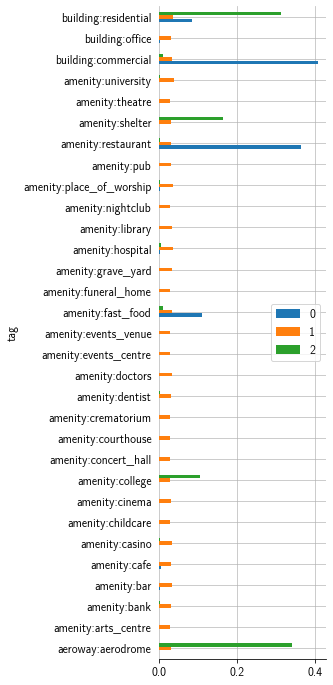

In [51]:
_df = all_evalues_seek.apply(lambda le: np.logaddexp(0, le))

pca = PCA(0.9)
pca.fit(_df)
pca.n_components_
lda = LatentDirichletAllocation(3, doc_topic_prior=1e-1)
z = pd.DataFrame(
    lda.fit_transform(_df),  # equivalent to log(e+1)
    index=_df.index,
)
components = pd.DataFrame(
    lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis],
    columns=_df.columns).T
ax = components.sort_index().plot(kind="barh", figsize=(3, 12))
(z.max(axis=1) > 0.95).mean()

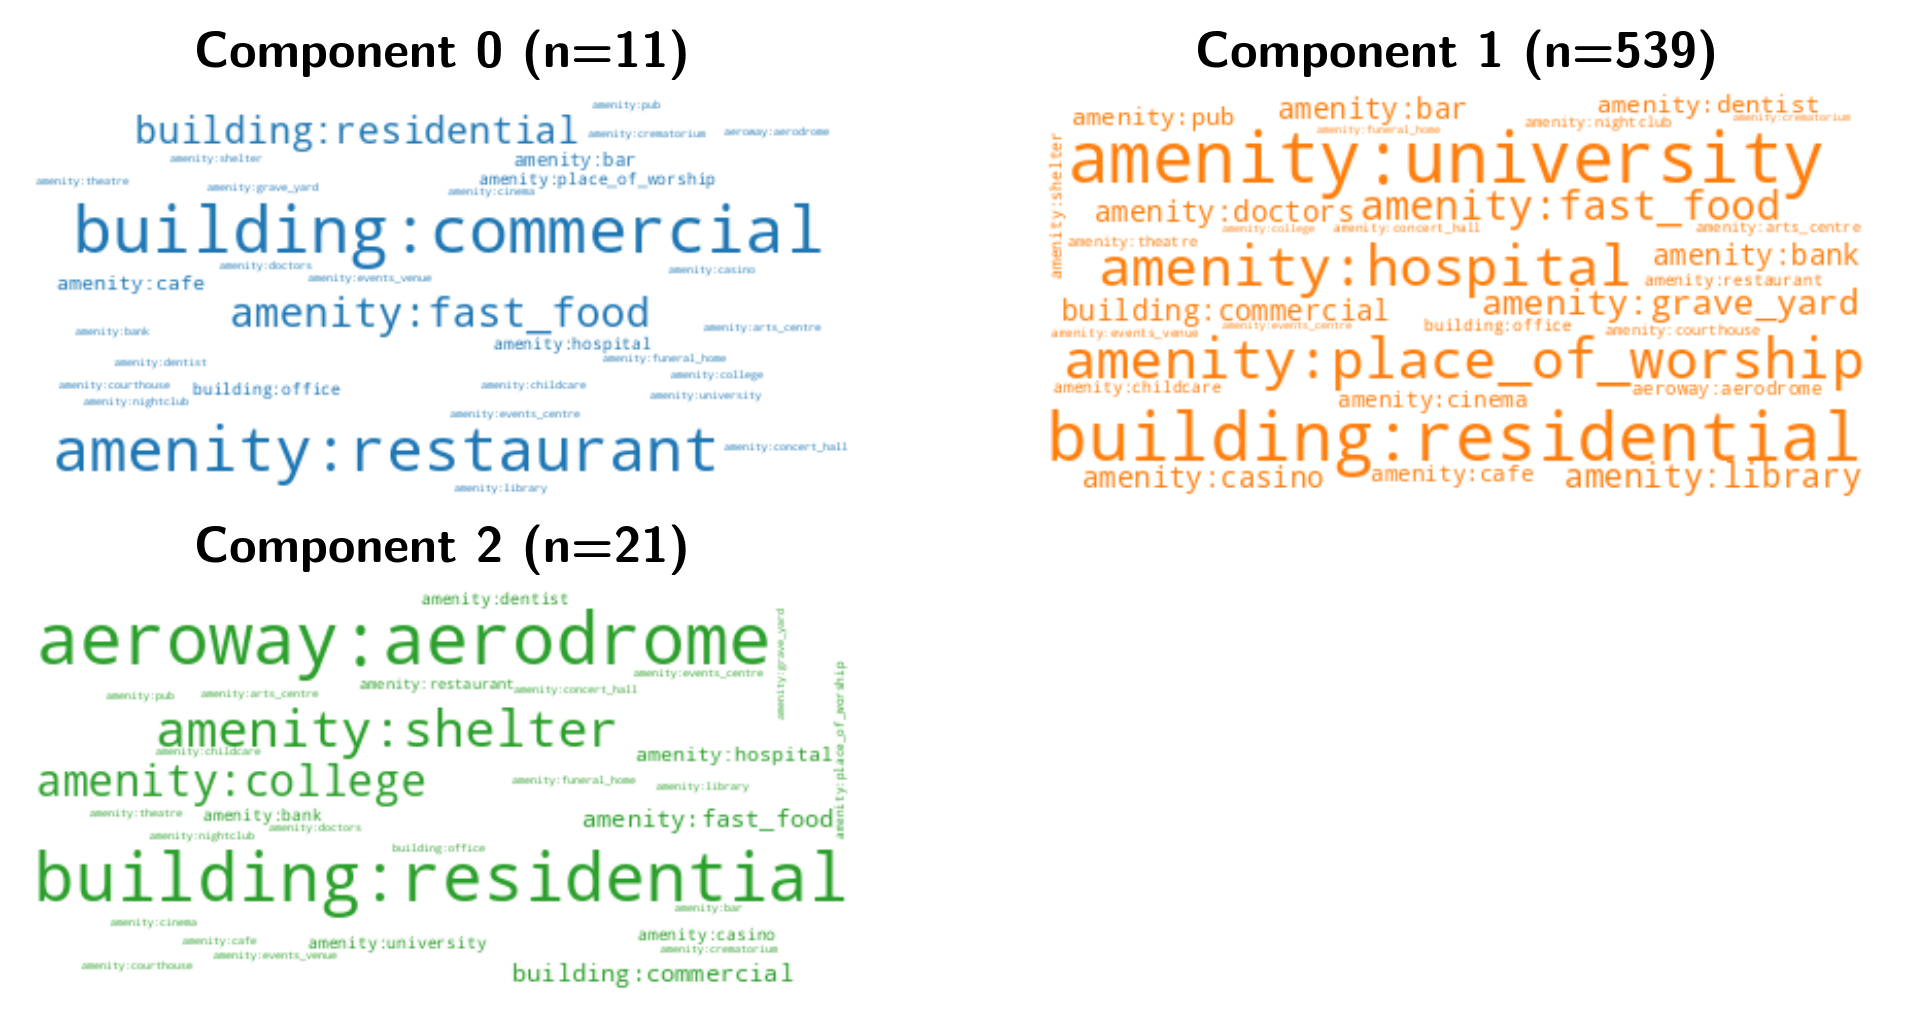

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), dpi=300)
_axes = axes.flatten()
ns = z.idxmax(axis=1).rename("topic").to_frame().groupby("topic").size()
for i in range(lda.n_components):
    wc = WordCloud(
        background_color="white",
        color_func=lambda *args, **kwargs: to_color(tab10.colors[i]),
        relative_scaling=0.5
    )
    wc.generate_from_frequencies(components[i].to_dict())
    _axes[i].imshow(wc, interpolation="bilinear")
    _axes[i].axis("off")
    _axes[i].set(
        title=f"Component {i} (n={ns.loc[i]})",
    )
_axes[3].axis("off")
fig.savefig("figures/lda-seek-word-cloud.png", bbox_inches="tight")

0.8704028021015762

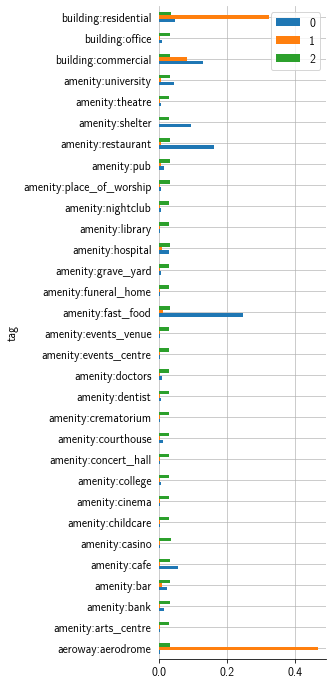

In [53]:
_df = all_evalues_avoid.apply(lambda le: np.logaddexp(0, le))
pca = PCA(0.9)
pca.fit(_df)
pca.n_components_
lda = LatentDirichletAllocation(3, doc_topic_prior=1e-1)
z = pd.DataFrame(
    lda.fit_transform(_df),  # equivalent to log(e+1)
    index=_df.index,
)
components = pd.DataFrame(
    lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis],
    columns=_df.columns).T
ax = components.sort_index().plot(kind="barh", figsize=(3, 12))
(z.max(axis=1) > 0.95).mean()

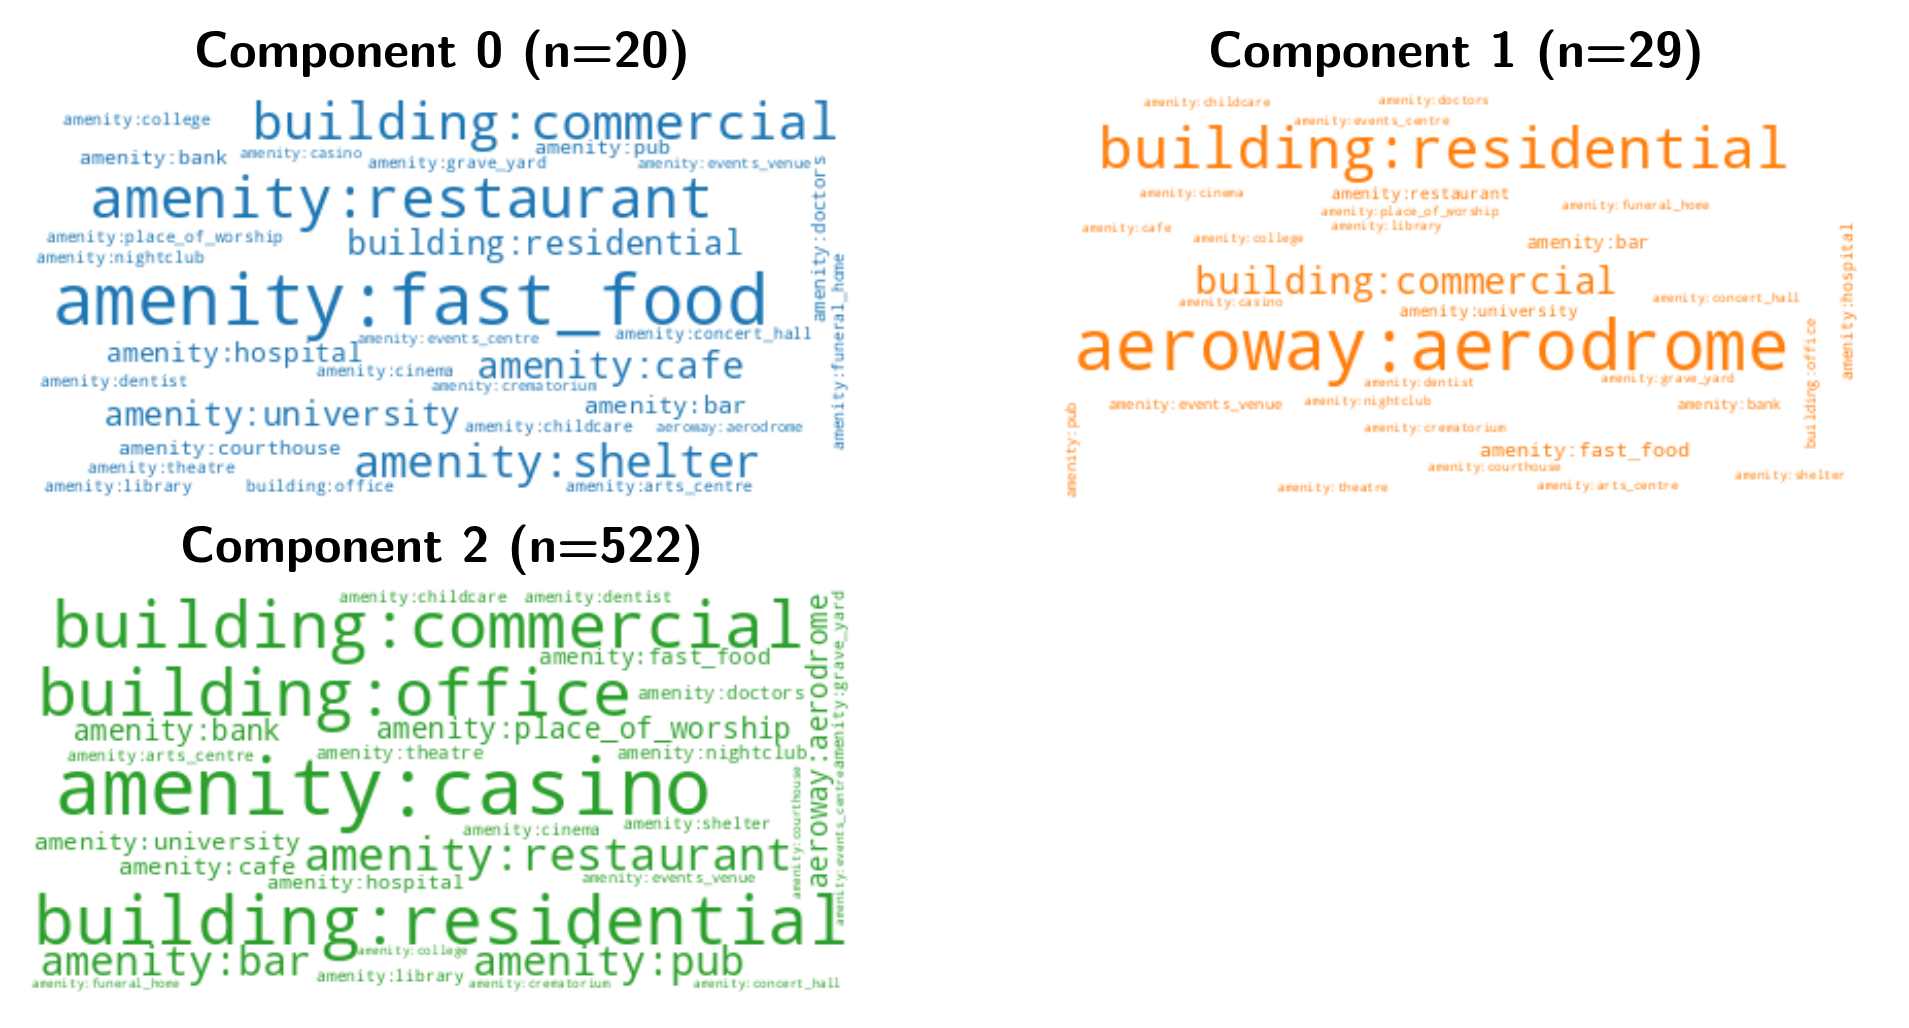

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), dpi=300)
_axes = axes.flatten()
ns = z.idxmax(axis=1).rename("topic").to_frame().groupby("topic").size()
for i in range(lda.n_components):
    wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: to_color(tab10.colors[i]))
    wc.generate_from_frequencies(components[i].to_dict())
    _axes[i].imshow(wc, interpolation="bilinear")
    _axes[i].axis("off")
    _axes[i].set(
        title=f"Component {i} (n={ns.loc[i]})",
    )
_axes[3].axis("off")
fig.savefig("figures/lda-avoid-word-cloud.png", bbox_inches="tight")

In [55]:
from textwrap import dedent

def to_tex_def(name, value):
    return f"\\def\\r{name}{{{value}\\xspace}}"

def to_tex_defs(**kwds):
    for name, value in kwds.items():
        yield to_tex_def(name, value)

with open("figures/result-data.tex", "w") as fp:
    fp.write("\n".join(to_tex_defs(
        NumberOfTests=pvalues_seek.size,
        NumberOfDrivers=len(selected_drivers),
        NumberOfTags=len(select_tags),
        NumberSeekSig=p_table_seek.n.sum(),
        NumberAvoidSig=p_table_avoid.n.sum(),
        MinNumberServiceStop=min_number_service_stops,
        ConfidenceLevel=1-2*alpha,
        NumberOfArms=n_arms,
        TotalNumberOfDrivers=total_number_of_drivers,
        AggregateNumberOfStops=len(stop_tags_ts),
        NumberAggAvoidSig=len(agg_avoid_p_table),
        NumberAggSeekSig=len(agg_seek_p_table),
    )))